# The Goal
- Improve logistic regression model performance with hyperparameter tuning targeted at reducing overfitting. (regularization, epochs, classification threshold)
- Create functions to make training/testing pipeline more efficient
- Utilize Grid Search if educated guesses make no progress.


# Step 1: Reproduce SMOTE training set
(conditions of last best result)

In [25]:
import tensorflow as tf
import sklearn
import numpy as np
from numpy import where
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, auc, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import collections
from collections import Counter
import logging
import os
import sys
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [2]:
df = pd.read_csv('./creditcard.csv')
X = df.drop('Class', axis=1).values
Y = df.Class.values

seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

# applying SMOTE
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## Step 2: Hyperparameter tuning cycle on logistic regression

In [9]:
## logistic regression

def create_lg_model(lglambda=0, threshold=0.5, auc_curve="ROC", input_shape=0):
    seed=1234
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = tf.keras.Sequential()

    if input_shape != 0:
        model.add(tf.keras.Input(input_shape, ))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=lglambda)))

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=[tf.keras.metrics.AUC(curve=auc_curve), tf.keras.metrics.Precision(thresholds=threshold), tf.keras.metrics.Recall(thresholds=threshold)]
    )

    return model

In [10]:
# create model
lgmodel = KerasClassifier(build_fn=create_lg_model, verbose=0)

# define the grid search parameters
lglambda = [0.1, 0.05, 0.01]
lgepochs = [10, 15, 25]
param_grid = dict(lglambda=lglambda, epochs=lgepochs)

# generating predefined cv
x_grid = np.append(x_train_smote, x_cv, axis=0)
y_grid = np.append(y_train_smote, y_cv, axis=0)
train_indices = np.full((x_train_smote.shape[0]), -1, dtype=int)
cv_indices = np.full((x_cv.shape[0]), 0, dtype=int)
test_fold = np.append(train_indices, cv_indices)
ps = PredefinedSplit(test_fold)

In [11]:
scoring = {"AUC":"roc_auc", "Precision":"precision", "Recall":"recall"}

grid = GridSearchCV(
    estimator= lgmodel,
    param_grid=param_grid,
    scoring=scoring,
    cv=ps,
    verbose=2,
    refit="AUC",
)

grid_result = grid.fit(x_grid, y_grid)


Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ............................epochs=10, lglambda=0.1; total time= 8.9min
[CV] END ...........................epochs=10, lglambda=0.05; total time= 3.2min
[CV] END ...........................epochs=10, lglambda=0.01; total time= 3.0min
[CV] END ............................epochs=15, lglambda=0.1; total time= 4.5min
[CV] END ...........................epochs=15, lglambda=0.05; total time= 4.6min
[CV] END ...........................epochs=15, lglambda=0.01; total time= 5.7min
[CV] END ............................epochs=25, lglambda=0.1; total time= 7.7min
[CV] END ...........................epochs=25, lglambda=0.05; total time= 7.7min
[CV] END ...........................epochs=25, lglambda=0.01; total time= 8.0min


In [12]:
lg_grid_results = grid_result.cv_results_
lg_grid_results.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_epochs', 'param_lglambda', 'params', 'split0_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_Precision', 'mean_test_Precision', 'std_test_Precision', 'rank_test_Precision', 'split0_test_Recall', 'mean_test_Recall', 'std_test_Recall', 'rank_test_Recall'])

In [17]:
display(lg_grid_results['params'])

[{'epochs': 10, 'lglambda': 0.1},
 {'epochs': 10, 'lglambda': 0.05},
 {'epochs': 10, 'lglambda': 0.01},
 {'epochs': 15, 'lglambda': 0.1},
 {'epochs': 15, 'lglambda': 0.05},
 {'epochs': 15, 'lglambda': 0.01},
 {'epochs': 25, 'lglambda': 0.1},
 {'epochs': 25, 'lglambda': 0.05},
 {'epochs': 25, 'lglambda': 0.01}]

In [28]:
df_lg_auc = pd.DataFrame(data=np.array(lg_grid_results['mean_test_AUC']).reshape(3,3), index=[10, 15, 25], columns=[0.1, 0.05, 0.01])
df_lg_precision = pd.DataFrame(data=np.array(lg_grid_results['mean_test_Precision']).reshape(3,3), index=[10, 15, 25], columns=[0.1, 0.05, 0.01])
df_lg_recall = pd.DataFrame(data=np.array(lg_grid_results['mean_test_Recall']).reshape(3,3), index=[10, 15, 25], columns=[0.1, 0.05, 0.01])
df_lg_f1 = pd.DataFrame(2 * df_lg_precision * df_lg_recall / (df_lg_precision + df_lg_recall))

display("auc scores")
display(df_lg_auc)
display("precision scores")
display(df_lg_precision)
display("recall scores")
display(df_lg_recall)
display("f1 scores")
display(df_lg_f1)

'auc scores'

,0.10,0.05,0.01
10,0.520019,0.747196,0.945863
15,0.871445,0.840363,0.926260
25,0.769760,0.780376,0.884833


'precision scores'

,0.10,0.05,0.01
10,0.001358,0.132184,0.175439
15,0.157068,0.138249,0.312500
25,0.389831,0.382353,0.425287


'recall scores'

,0.10,0.05,0.01
10,1.000000,0.479167,0.833333
15,0.625000,0.625000,0.833333
25,0.479167,0.541667,0.770833


'f1 scores'

,0.10,0.05,0.01
10,0.002712,0.207207,0.289855
15,0.251046,0.226415,0.454545
25,0.429907,0.448276,0.548148


epochs=25 and lambda=0.01 seem to yield highest f1 score. Conduct threshold tuning with these lambda=0.01, epochs=25 to improve f1 score. Also specifying input shape this time.

In [20]:
NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)
m = create_lg_model(lglambda=0.01, input_shape=x_train_smote.shape[1])
m.fit(x_train_smote, y_train_smote, epochs=25, callbacks=[tensorboard], validation_data = (x_cv, y_cv))

Train on 410818 samples, validate on 36313 samples
Epoch 1/25
410818/410818 [==============================] - 26s 63us/sample - loss: 21.3997 - auc_11: 0.8382 - precision_11: 0.8219 - recall_11: 0.8439 - val_loss: 18.1303 - val_auc_11: 0.8354 - val_precision_11: 0.0033 - val_recall_11: 1.0000
Epoch 2/25
410818/410818 [==============================] - 23s 57us/sample - loss: 20.6841 - auc_11: 0.8565 - precision_11: 0.8437 - recall_11: 0.8583 - val_loss: 5.1194 - val_auc_11: 0.9253 - val_precision_11: 0.2186 - val_recall_11: 0.8333c_11: 0.8564 - precision_11: 0.8434 - recall_11 - ETA: 6s - loss: 20.9158 - auc_11: 0.8555 - prec - - ETA: 0s - loss: 20.7686 - auc_11: 0.8563 - precision_11: 0.8435 - r - ETA: 0s - loss: 20.7114 - auc_11: 0.8564 - precision_11: 0.8436 - recall_11: 0.85
Epoch 3/25
410818/410818 [==============================] - 22s 53us/sample - loss: 21.3374 - auc_11: 0.8538 - precision_11: 0.8422 - recall_11: 0.8548 - val_loss: 6.4846 - val_auc_11: 0.9445 - val_precision_1

In [22]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6255), started 0:00:35 ago. (Use '!kill 6255' to kill it.)

'optimal threshold: 1.0'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36265
           1       0.61      0.77      0.68        48

    accuracy                           1.00     36313
   macro avg       0.80      0.89      0.84     36313
weighted avg       1.00      1.00      1.00     36313



'macro avg f1 score 0.84, improvement from 0.55 (results without hyperparameter tuning)'

'roc auc score: 0.8850857691070363'

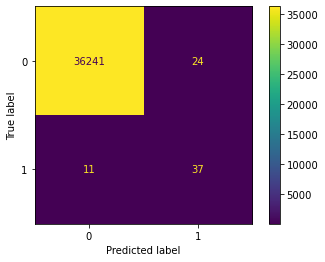

In [31]:
preds = m.predict_proba(x_cv)
fpr, tpr, thresholds = roc_curve(y_cv, preds)
opt_index = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_index]
display(f'optimal threshold: {opt_threshold}')

pred_class = list((preds >= opt_threshold).astype(int))
pred_class = list(map(lambda x: x[0], pred_class))

cm = confusion_matrix(y_cv, pred_class)
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
dp1.plot()
print(classification_report(y_cv, pred_class))
display('macro avg f1 score 0.84, improvement from 0.55 (results without hyperparameter tuning)')
display(f'roc auc score: {roc_auc_score(y_cv, pred_class)}')


Threshold tuning has greatly reduced the number of false positives. Macro average of f1 score has improve greatly (from 0.55 baseline to 0.84)

In [33]:
# saving best performing model
lgmodel_v6 = m.save('./models/lgmodel_v6')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/lgmodel_v6/assets


In [36]:
lgmodel_v6 = tf.keras.models.load_model('./models/lgmodel_v6')